In [1]:
import numpy as np
from scipy.sparse import issparse, csc_matrix
import time
from sklearn.model_selection import train_test_split
import datetime
import matplotlib.pyplot as plt
import matplotlib
import warnings
matplotlib.use('Tkagg')
%matplotlib inline

## Useful functions

In [2]:
def preprocess_data(X, y, test_size=0.2, scale=True):
    """
    Split and scale data.

    Args:
        X: Feature matrix (sparse or dense)
        y: Labels
        test_size: Proportion for test split
        scale: Whether to standardize features

    Returns:
        X_train, X_test, y_train, y_test
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42
    )

    """if scale:
        scaler = StandardScaler(with_mean=False)  # Preserve sparsity (dividing by sd)
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    """
    return X_train, X_test, y_train, y_test

In [3]:
def load_svm_file(file_path, zero_based=True):
    """
    Load data from a file.

    Args:
        file_path: Path to the .binary file
        zero_based: Whether feature indices start at 0 (True) or 1 (False)

    Returns:
        X: scipy.sparse.csc_matrix of features (with respect to columns)
        y: numpy array of labels
    """
    labels = []
    rows = []
    cols = []
    data = []

    with open(file_path, 'r') as f:
        for i, line in enumerate(f):
            parts = line.strip().split()
            labels.append(float(parts[0]))

            for feat in parts[1:]:
                idx, val = feat.split(':')
                idx = int(idx) - (0 if zero_based else 1)
                rows.append(i)
                cols.append(idx)
                data.append(float(val))

    # Create sparse matrix
    X = csc_matrix((data, (rows, cols))).tocsc()
    y = np.array(labels)

    return X, y

In [4]:
def load_dataset(file_path):
    """Combined loader and preprocessor"""
    X, y = load_svm_file(file_path)
    return preprocess_data(X, y)

## Algorithms

### CDPER and its variation with H_i in denominator

In [5]:
class CDPER_L2SVM:
    def __init__(self, C=1.0, sigma=0.05, beta=0.7, max_iter=1000, tol=1e-4, random_state=42, exact_hessian=True, max_time=70):
        self.C = C
        self.sigma = sigma
        self.beta = beta
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.exact_hessian = exact_hessian
        self.max_time = max_time
        self.w = None
        self.z = None
        self.H = None
        self.lambdas = {}

        self.objective_values = []
        self.gradient_values = []
        self.gradient_norm_values = []
        self.accuracies = []

    def _precompute_H(self, X):
        """
            Precompute diagonal elements of Hessian matrix:
            H_i = 1 + 2C * sum_j x_ji^2
            Used for second derivatives during coordinate updates.
        """
        self.H = 1 + 2 * self.C * (X.power(2).sum(axis=0)).A1

    def _get_active_mask(self, y):
        """
            Identify samples violating margin (i.e., 1 - y*z > 0).
            Only these contribute to gradient updates.
        """
        return (1 - y * self.z) > 0

    def _d_prime_i(self, X, y, i):
        """
            Compute gradient (first derivative) w.r.t. w[i]
        """
        col_start = X.indptr[i]
        col_end = X.indptr[i + 1]
        indices = X.indices[col_start:col_end]
        data = X.data[col_start:col_end]

        active_mask = self._get_active_mask(y)[indices]
        if not np.any(active_mask):
            return self.w[i]

        y_active = y[indices[active_mask]]
        z_active = self.z[indices[active_mask]]
        data_active = data[active_mask]

        margins = 1 - y_active * z_active
        d_prime_i = self.w[i] - 2 * self.C * np.sum(data_active * y_active * margins)
        self.gradient_values[i] = d_prime_i
        return d_prime_i

    def _d_double_prime_i(self, X, y, i, exact=False):
        """
        Return the second derivative (Hessian diagonal) for feature i.

        exact:  If True, compute using only active set (violating examples)
                If False (default), return precomputed H[i] as upper bound
        """
        if not exact:
            return self.H[i]

        col_start = X.indptr[i]
        col_end = X.indptr[i + 1]
        indices = X.indices[col_start:col_end]
        data = X.data[col_start:col_end]

        active_mask = self._get_active_mask(y)[indices]
        if not np.any(active_mask):
            return 1.0

        data_active = data[active_mask]
        return 1.0 + 2 * self.C * np.sum(data_active ** 2)

    def _newton_direction(self, X, y, i):
        """
            Compute Newton direction for coordinate i:
            direction = -gradient / hessian
        """
        d_prime = self._d_prime_i(X, y, i)
        d_double_prime = self._d_double_prime_i(X, y, i, exact=self.exact_hessian)
        return -d_prime / d_double_prime if d_double_prime != 0 else 0.0

    def _line_search(self, X, y, i, d, lambda_bar):
        """
            Perform backtracking line search to ensure sufficient objective decrease:
            D(λd) - D(0) <= -σ * (λd)^2
        """
        col_start = X.indptr[i]
        col_end = X.indptr[i + 1]
        indices = X.indices[col_start:col_end]
        data = X.data[col_start:col_end]

        D0 = self._objective(y=y)

        lam = 1.0
        while True:
            if lam <= lambda_bar:
                return lam  # skip evaluating D_i(λd), inequality is guaranteed

            # Otherwise evaluate the objective difference
            delta = lam * d
            z_new = self.z.copy()
            z_new[indices] += delta * data
            D_new = self._objective(w=self.w, z=z_new, y=y)

            if (D_new - D0) <= -self.sigma * (delta ** 2):
                return lam

            lam *= self.beta
            if lam < 1e-10:
                return lam

    def _objective(self, w=None, z=None, y=None):
        """
            Compute the primal objective:
            0.5 * ||w||^2 + C * sum((1 - y*z)_+^2)
        """
        if w is None:
            w = self.w
        if z is None:
            z = self.z
        if y is None:
            raise ValueError("y must be provided")

        margins = 1 - y * z
        loss = np.sum(margins[margins > 0] ** 2)
        return 0.5 * np.dot(w, w) + self.C * loss

    def _compute_constant_lambda(self, X, y, i):
        """
            Precompute λ̄ upper bound from the line search theorem:
            λ̄ = d'' / (0.5 * H_i + σ)
        """
        dii = self._d_double_prime_i(X, y, i, exact=self.exact_hessian)

        col_start = X.indptr[i]
        col_end = X.indptr[i + 1]
        data = X.data[col_start:col_end]
        Xi_squared_sum = np.sum(data ** 2)

        Hi = 1 + 2 * self.C * Xi_squared_sum
        return dii / (0.5 * Hi + self.sigma), dii

    def _compute_gradient(self, X, y):
        """Compute full gradient ∇f(w) = w + 2C * X^T(y * (1 - y*Xw)_+"""
        active_mask = self._get_active_mask(y)
        margins = (1 - y * self.z) * active_mask
        return self.w + 2 * self.C * X.T.dot(y * margins)

    def fit(self, X, y, Xtest=None, ytest=None):
        if not issparse(X) or not isinstance(X, csc_matrix):
            X = csc_matrix(X)

        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.z = X @ self.w
        self.gradient_values = np.ones(n_features)
        self._precompute_H(X)

        start_even_before = time.time()
        for k in range(self.max_iter):
            perm = np.random.permutation(n_features)
            w_old = self.w.copy()

            inner_iter = 0

            for i in perm:
                inner_iter += 1

                if i not in self.lambdas:
                    self.lambdas[i], _ = self._compute_constant_lambda(X, y, i)

                d = self._newton_direction(X, y, i)
                if abs(d) < 1e-10:
                    continue

                lam = self._line_search(X, y, i, d, lambda_bar=self.lambdas[i])
                delta = lam * d
                self.w[i] += delta

                col_start = X.indptr[i]
                col_end = X.indptr[i + 1]
                indices = X.indices[col_start:col_end]
                data = X.data[col_start:col_end]
                self.z[indices] += delta * data

                elapsed = time.time() - start_even_before
                if inner_iter % 10000 == 9999:
                    f_w = self._objective(y=y)
                    self.objective_values.append((elapsed, f_w))
                    print(f"Inner iteration {inner_iter}, error = {1 - self.score(X, y):.6f}. Time elapsed: {elapsed:.2f} s.")

                    final_grad_norm = np.linalg.norm(self.gradient_values)
                    self.gradient_norm_values.append((elapsed, final_grad_norm))

                    if Xtest is not None and ytest is not None:
                        accuracy = self.score(Xtest, ytest)
                        self.accuracies.append((elapsed, accuracy))

                if elapsed > self.max_time:
                    return self

            elapsed = time.time() - start_even_before
            final_grad_norm = np.linalg.norm(self.gradient_values)
            self.gradient_norm_values.append((elapsed, final_grad_norm))

            if final_grad_norm < self.tol:  # Now using gradient norm for convergence
                print(f"Converged at iter {k+1}, grad_norm = {final_grad_norm:.4f}")
                break

            if Xtest is not None and ytest is not None:
                accuracy = self.score(Xtest, ytest)
                print(f"Accuracy on test set at iter {k+1}: {accuracy:.4f}")
                self.accuracies.append((elapsed, accuracy))


            print(f"Exited outer iteration loop number {k+1}, grad_norm = {final_grad_norm:.4f}, time: {elapsed:.2f} s.")
            print(f"And moreover, objective value function: {self.objective_values[-1][1]}")
        return self

    def predict(self, X):
        if issparse(X):
            return np.sign(X @ self.w)
        return np.sign(np.dot(X, self.w))

    def score(self, X, y):
        return np.mean(self.predict(X) == y)

    def get_params(self, deep=True):
        return {'C': self.C, 'sigma': self.sigma, 'beta': self.beta,
                'max_iter': self.max_iter, 'tol': self.tol,
                'random_state': self.random_state,
                'exact_hessian': self.exact_hessian}

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

### Accelerated - Coordinate boosted

In [6]:
class Coordinate_boosted():
    def __init__(self, C=1.0, max_iter=10000, tol=1e-8, sigma=0.01, beta=0.5, verbose=True, max_time=200):
        self.C = C
        self.max_iter = max_iter
        self.tol = tol
        self.sigma = sigma
        self.gamma = 0
        self.beta = beta
        self.verbose = verbose
        self.w = None
        self.z = None
        self.k = 0

        self.max_time = max_time
        self.objective_values = []
        self.gradient_norm_values = []
        self.accuracies = []
    def _precompute_H(self, X):
        """
            Precompute diagonal elements of Hessian matrix:
            H_i = 1 + 2C * sum_j x_ji^2
            Used for second derivatives during coordinate updates.
        """
        return  1 + 2 * self.C * (X.power(2).sum(axis=0)).A1

    def _compute_full_gradient(self, X, y):
        """Compute full gradient vector ∇f(w) = w + 2C * X^T(y * (1 - y*Xw)_+"""
        margins = 1 - y * (X @ self.x)
        active = margins > 0
        return self.x + 2 * self.C * X.T.dot(y * active * margins)

    def _d_double_prime_i_0(self, X, y, i, exact = True):


        if not exact:
            return self.H[i]
        # Wyciągamy niezerowe elementy kolumny i z csc_matrix X
        col_start = X.indptr[i]
        col_end = X.indptr[i + 1]
        indices = X.indices[col_start:col_end]  # wiersze niezerowych elementów kolumny i
        data = X.data[col_start:col_end]       # wartości tych elementów

        # Obliczamy marginesy
        margins = 1 - y * self.z
        # Tworzymy maskę aktywnych przykładów (tych, które łamią warunek margin > 0)
        active_mask = margins[indices] > 0

        if not np.any(active_mask):
            return 1.0  # tylko regularizacja, brak strat

        data_active = data[active_mask]

        return 1.0 + 2 * self.C * np.sum(data_active ** 2)



    def fit(self, X, y_labels, Xtest=None, ytest=None):
        if not issparse(X) or not isinstance(X, csc_matrix):
            raise ValueError("X must be a CSC (Compressed Sparse Column) matrix")

        start_time = time.time()

        self.n = X.shape[1]
        self.x = np.zeros(self.n, dtype=np.float64)  # x0 docelowo szukany wektor

        self.v = self.x.copy()
        self.Xx_cashed = X.dot(self.x)
        self.Xv_cashed = X @ self.v 
        self.y_cashed = np.zeros(self.n, dtype=np.float64)
        self.H = self._precompute_H(X)
        gamma_k = 0.0
        gamma_prev = gamma_k
        i = np.random.randint(0, self.n,self.max_iter)
        iter = 0

        self.gradient = np.zeros(self.n)

        for k in i:
            # -- 1. Wyznacz gamma_k rozwiązując równanie kwadratowe -- check
            #gamma_prev = gamma_k
            B = (self.sigma * gamma_prev**2 - 1) / self.n
            C = -gamma_prev**2

            discriminant = B**2 - 4 * C
            gamma_k = (-B + np.sqrt(discriminant)) / 2
            
             # -- 2. Oblicz alfa, beta -- check
            alpha_k = (self.n - gamma_k * self.sigma) / (gamma_k * (self.n**2 - self.sigma))
            beta_k = 1 - (gamma_k * self.sigma) / self.n

            # -- 4. Wybierz losowy indeks --

            col_start = X.indptr[k]
            col_end = X.indptr[k + 1]
            row_indices = X.indices[col_start:col_end]  # wiersze niezerowych elementów kolumny i
            data = X.data[col_start:col_end] 


            # -- 3. y_k = α_k * v + (1 - α_k) * w -- check

            #self.y_cashed  = alpha_k * self.v + (1 - alpha_k) * self.x
            y_k_value = alpha_k * self.v[k] + (1 - alpha_k) * self.x[k]

                        

            # -- 5. Licz gradient po y_k (czyli po ∇f(y)[i]) --
            margins = 1 - y_labels * self.Xx_cashed
            active = margins > 0




            z_y_rows = alpha_k * self.Xv_cashed[row_indices] + (1 - alpha_k) * self.Xx_cashed[row_indices]
            margins_rows = 1 - y_labels[row_indices] * z_y_rows
            mask = margins_rows > 0



            if not np.any(mask):
                grad_i = y_k_value
            else:
                filtered_data = data[mask]                             # X_{j, i_k}
                filtered_y = y_labels[row_indices][mask]               # y_j
                filtered_margins = margins_rows[mask]                  # (1 - y_j * z_j)
                grad_sum = np.sum(filtered_data * filtered_y * filtered_margins)
                grad_i = y_k_value - 2 * self.C * grad_sum

            self.gradient[k] = grad_i

            # -- 6. Lipschitz dla i-tego kierunku (aproksymacja Hessianu) --
            dii = self._d_double_prime_i_0(X, y_labels, k, exact = False)

            # -- 7. Krok po i-tej współrzędnej (update x[i]) --
            delta_i = -grad_i / dii
            self.x[k] += delta_i
            self.Xx_cashed[row_indices] += delta_i * data

            # -- 8. Update v (momentum) --
            old_vi = self.v[k]
            self.v[k] = beta_k * self.v[k] + (1 - beta_k) * y_k_value - (gamma_k / dii) * grad_i
            self.Xv_cashed[row_indices] += (self.v[k] - old_vi) * data

            # -- 9. Zaktualizuj gamma_prev --
            gamma_prev = gamma_k

            elapsed = time.time() - start_time
            # -- 10. Monitoring co 100 iteracji --
            if iter % 100000 == 99999:
                # Store objective value
                obj_val = self._objective(X, y_labels)
                self.objective_values.append((elapsed, obj_val))

                # Compute and store full gradient
                current_gradient = self._compute_full_gradient(X, y_labels)

                # Compute and store gradient norm
                grad_norm = np.linalg.norm(current_gradient)
                self.gradient_norm_values.append((elapsed, grad_norm))

                # Store accuracy if test set provided
                if Xtest is not None and ytest is not None:
                    accuracy = self.score(Xtest, ytest)
                    self.accuracies.append((elapsed, accuracy))

                acc = self.score(X, y_labels)
                print(f"[{iter:5d}] acc = {acc:.4f} , time = {datetime.datetime.now()}")

                if elapsed > self.max_time:
                    break
            iter +=1

    def predict(self, X):
        return np.sign(X @ self.x)

    def score(self, X, y):
        return np.mean(self.predict(X) == y)
            
    def _objective(self, X, y):
        margins = 1 - y * (X@self.x)
        loss = np.sum((margins[margins > 0]) ** 2)
        return 0.5 * np.dot(self.x, self.x) + self.C * loss

### Online algorithm (every time column is chosen randomly)

In [57]:
class CDPER_L2SVM_Online:
    def __init__(self, C=1.0, max_iter=100000000, tol=1e-8, sigma=0.01, beta=0.5, verbose=True, max_time=200):
        self.C = C
        self.max_iter = max_iter
        self.tol = tol
        self.sigma = sigma
        self.beta = beta
        self.verbose = verbose
        self.w = None
        self.z = None
        self.H = None
        self.lambdas = {}
        self.times = []
        self.relative_diffs = []
        self.obj_values =[]
        self.time_start = time.time()
        self.max_time = max_time


        self.max_time = max_time
        self.objective_values = []
        self.gradient_norm_values = []
        self.accuracies = []

    def _precompute_H(self, X):
        """
            Precompute diagonal elements of Hessian matrix:
            H_i = 1 + 2C * sum_j x_ji^2
            Used for second derivatives during coordinate updates.
        """
        return  1 + 2 * self.C * (X.power(2).sum(axis=0)).A1
    
    def _d_prime_i_0(self, X, y, i):
        margins = 1 - y * self.z
        active = margins > 0

        # Indeksy kolumny i w formacie CSC
        col_start = X.indptr[i]
        col_end = X.indptr[i + 1]
        row_indices = X.indices[col_start:col_end]
        data = X.data[col_start:col_end]

        # Maska aktywnych przykładów w tych wierszach
        mask = active[row_indices]

        if not np.any(mask):
            return self.w[i]  # brak aktywnych przykładów, gradient to tylko w[i]

        filtered_y = y[row_indices][mask]
        filtered_margins = margins[row_indices][mask]
        filtered_data = data[mask]

        gradient_sum = np.sum(filtered_data * filtered_y * filtered_margins)

        d_prime_i = self.w[i] - 2 * self.C * gradient_sum
        self.gradient_values[i] = d_prime_i

        return d_prime_i


    def _d_double_prime_i_0(self, X, y, i):
        # Wyciągamy niezerowe elementy kolumny i z csc_matrix X
        col_start = X.indptr[i]
        col_end = X.indptr[i + 1]
        indices = X.indices[col_start:col_end]  # wiersze niezerowych elementów kolumny i
        data = X.data[col_start:col_end]       # wartości tych elementów

        # Obliczamy marginesy
        margins = 1 - y * self.z
        # Tworzymy maskę aktywnych przykładów (tych, które łamią warunek margin > 0)
        active_mask = margins[indices] > 0

        if not np.any(active_mask):
            return 1.0  # tylko regularizacja, brak strat

        data_active = data[active_mask]


        return 1.0 + 2 * self.C * np.sum(data_active ** 2)


    def _newton_direction(self, X, y, i,  denominator = None):

        numerator = self._d_prime_i_0(X, y, i)

        if (denominator == None):
            denominator = self._d_double_prime_i_0(X, y, i)
        return -numerator / denominator if denominator != 0 else 0.0

    def _d_i_z(self, X, y, i, z):
        x_col = X[:, i]
        indices = x_col.indices
        delta = z * x_col.data
        z_new_part = self.z[indices] + delta
    
        margins_part = 1 - y[indices] * z_new_part
        active = margins_part > 0
        loss_term = np.sum(margins_part[active] ** 2)
    
        w_norm_sq = np.dot(self.w, self.w) + 2 * z * self.w[i] + z**2
        return 0.5 * w_norm_sq + self.C * loss_term


    def _compute_threshhold_lambda(self, X, y, i):
  
        dii = self._d_double_prime_i_0(X, y, i)

        return dii / (0.5 * self.H[i]+ self.sigma), dii



    def _compute_lambda(self, X, y, i, d):
        lambda_bar = self.lambdas[i]
        if abs(d) < 1e-12:
            return 0.0
        if 1.0 <= lambda_bar:
            return 1.0

        # Otherwise, perform line search
        D0 = self._d_i_z(X, y, i, 0)
        k = 0
        while True:
            lam = self.beta ** k
            z = lam * d
            Dz = self._d_i_z(X, y, i, z)
            if Dz - D0 <= -self.sigma * (z ** 2):
                return lam
            k += 1
            if k > 20:  # Prevent infinite loop
                return lam

    def _coordinate_update(self, X, y, i, z, dii=None):
        d = self._newton_direction(X, y, i, dii)
        if abs(d) < 1e-12:
            return

        lam = 1.0
        if self.lambdas[i] < 1.0:  # Only do line search if needed
            lam = self._compute_lambda(X, y, i, d)

        delta = lam * d
        self.w[i] += delta

        # Efficient update of self.z for sparse column
        col_start = X.indptr[i]
        col_end = X.indptr[i + 1]
        indices = X.indices[col_start:col_end]
        data = X.data[col_start:col_end]

        self.z[indices] += delta * data



    def fit(self, X, y, X_test, y_test):
        print(f"start  time = {datetime.datetime.now()}")
        if not issparse(X) or not isinstance(X, csc_matrix):
            raise ValueError("X must be a CSC (Compressed Sparse Column) matrix")
        #start with initial w0
        
        self.w = np.zeros(X.shape[1],dtype=np.float64)
        self.H = self._precompute_H(X)
        self.z = X.dot(self.w)

        self.gradient_values = np.ones(X.shape[1])

        start_even_before = time.time()
        for iteration in range(self.max_iter):
            i = np.random.randint(0, X.shape[1])
            if i not in self.lambdas:
                self.lambdas[i], dii = self._compute_threshhold_lambda(X, y, i)
            else:
                dii = None
            self._coordinate_update(X, y, i, dii)
            
            elapsed = time.time() - start_even_before
            if iteration % 10000 == 9999:
                f_w = self._objective(y=y)
                self.objective_values.append((elapsed, f_w))
                print(f"Inner iteration {iteration}, error = {1 - self.score(X, y):.6f}. Time elapsed: {elapsed:.2f} s.")

                final_grad_norm = np.linalg.norm(self.gradient_values)
                self.gradient_norm_values.append((elapsed, final_grad_norm))
                if X_test is not None and y_test is not None:
                    accuracy = self.score(X_test, y_test)
                    print(f"Accuracy on test set at iter {iteration+1}: {accuracy:.4f}")
                    self.accuracies.append((elapsed, accuracy))

                if elapsed > self.max_time:
                    return self
    
                elapsed = time.time() - start_even_before
                final_grad_norm = np.linalg.norm(self.gradient_values)
                self.gradient_norm_values.append((elapsed, final_grad_norm))
    
                print(f"finish  time = {datetime.datetime.now()}")
        
                print(f"Exited outer iteration loop number {iteration+1}, grad_norm = {final_grad_norm:.4f}, time: {elapsed:.2f} s.")
                print(f"And moreover, objective value function: {self.objective_values[-1][1]}")
        return self


    def predict(self, X):
        return np.sign(X @self.w)

    def score(self, X, y):
        return np.mean(self.predict(X) == y)
        
    def _objective(self, y):
        margins = 1 - y * self.z
        loss = np.sum((margins[margins > 0]) ** 2)
        return 0.5 * np.dot(self.w, self.w) + self.C * loss

## Testing and saving functions

In [8]:
def testing(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train, X_test, y_test)
    score_model = model.score(X_test, y_test)
    print(f"Accuracy: {score_model}")
    print(model.objective_values)
    print(model.gradient_norm_values)
    return model

In [9]:
def save_model(model, model_name, data):
    np.save(f'../results/metrics/{model_name}_{data}_objective_values.npy', model.objective_values)
    np.save(f'../results/metrics/{model_name}_{data}_gradient_values.npy', model.gradient_norm_values)
    np.save(f'../results/metrics/{model_name}_{data}_accuracy_values.npy', model.accuracies)

In [10]:
def save_true_model(model, data, X_train, y_train):
    model.fit(X_train, y_train)
    f_w_star = model.objective_values[-1][1]
    np.save(f'../results/metrics/true_{data}_value.npy', f_w_star)
    print(f_w_star)

## Datasets

#### Select dataset

In [11]:
dataset = 'real-sim'

You can use:

"news20", "real-sim", "rcv1_test"

"synthetic1", "synthetic2", "synthetic3"

In [12]:
def load_actual_dataset(dataset):
    if dataset == 'news20':
        X, y = load_svm_file('../data/paper_data/news20.binary')
        data = 'news20'
        seconds = 200
    
    elif dataset == 'real-sim':
        X, y = load_svm_file('../data/paper_data/real-sim.binary')
        data = 'real-sim'
        seconds = 400
    
    elif dataset == 'rcv1_test':
        X, y = load_svm_file('../data/paper_data/rcv1_test.binary')
        data = 'rcv1_test'
        seconds = 500
    
    elif dataset == 'synthetic1':
        X, y = load_svm_file('../data/synthetic_data/synthetic1.binary')
        data = 'synthetic1'
        seconds = 200
        
    elif dataset == 'synthetic2':
        X, y = load_svm_file('../data/synthetic_data/synthetic2.binary')
        data = 'synthetic2'
        seconds = 200
        
    elif dataset == 'synthetic3':
        X, y = load_svm_file('../data/synthetic_data/synthetic3.binary')
        data = 'synthetic3'
        seconds = 200
        
    else:
        warnings.warn("Please provide correct data name.", UserWarning)
        
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train = csc_matrix(X_train)
    X_test = csc_matrix(X_test)
    
    returned_dataset = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'data': data,
        'seconds': seconds
    } 
    return returned_dataset

## Train and store results

#### Model 1

In [13]:
data = load_actual_dataset('news20')
X_train, X_test, y_train, y_test = data['X_train'], data['X_test'], data['y_train'], data['y_test']

In [14]:
model1 = CDPER_L2SVM(C=1.0, max_iter=1000, random_state=42, max_time=data['seconds'])
testing(model1, X_train, y_train, X_test, y_test)

Inner iteration 9999, error = 0.374906. Time elapsed: 7.78 s.
Inner iteration 19999, error = 0.248375. Time elapsed: 15.06 s.
Inner iteration 29999, error = 0.208615. Time elapsed: 22.71 s.
Inner iteration 39999, error = 0.181295. Time elapsed: 30.41 s.
Inner iteration 49999, error = 0.158352. Time elapsed: 37.93 s.
Inner iteration 69999, error = 0.124531. Time elapsed: 55.44 s.
Inner iteration 79999, error = 0.110215. Time elapsed: 63.23 s.
Inner iteration 89999, error = 0.103401. Time elapsed: 72.11 s.
Inner iteration 99999, error = 0.093648. Time elapsed: 81.63 s.
Inner iteration 119999, error = 0.082958. Time elapsed: 97.07 s.
Inner iteration 129999, error = 0.076457. Time elapsed: 104.68 s.
Inner iteration 139999, error = 0.071393. Time elapsed: 110.93 s.
Inner iteration 149999, error = 0.067829. Time elapsed: 117.18 s.
Inner iteration 159999, error = 0.063578. Time elapsed: 122.56 s.
Inner iteration 169999, error = 0.059077. Time elapsed: 128.30 s.
Inner iteration 179999, error =

In [15]:
save_model(model1, 'CDPER_L2SVM', data['data'])

In [16]:
model1_true = CDPER_L2SVM(C=1.0, max_iter=1000, random_state=42, max_time= 5 * data['seconds'])
save_true_model(model1_true, data['data'], X_train, y_train)

Inner iteration 9999, error = 0.363528. Time elapsed: 13.00 s.
Inner iteration 19999, error = 0.270693. Time elapsed: 20.89 s.
Inner iteration 29999, error = 0.219617. Time elapsed: 29.59 s.
Inner iteration 39999, error = 0.184046. Time elapsed: 36.80 s.
Inner iteration 49999, error = 0.156977. Time elapsed: 44.41 s.
Inner iteration 59999, error = 0.143473. Time elapsed: 51.98 s.
Inner iteration 69999, error = 0.127782. Time elapsed: 59.19 s.
Inner iteration 79999, error = 0.112653. Time elapsed: 66.54 s.
Inner iteration 89999, error = 0.103588. Time elapsed: 73.91 s.
Inner iteration 99999, error = 0.096962. Time elapsed: 80.95 s.
Inner iteration 109999, error = 0.088272. Time elapsed: 87.88 s.
Inner iteration 119999, error = 0.081208. Time elapsed: 95.00 s.
Inner iteration 139999, error = 0.072581. Time elapsed: 109.36 s.
Inner iteration 149999, error = 0.066954. Time elapsed: 116.53 s.
Inner iteration 159999, error = 0.064266. Time elapsed: 124.51 s.
Inner iteration 169999, error = 0

#### Model 2

In [17]:
model2 = CDPER_L2SVM(C=1.0, max_iter=1000, random_state=42, exact_hessian=False, max_time=data['seconds'])
testing(model2, X_train, y_train, X_test, y_test)

Inner iteration 9999, error = 0.376469. Time elapsed: 11.42 s.
Inner iteration 19999, error = 0.264629. Time elapsed: 25.47 s.
Inner iteration 29999, error = 0.215241. Time elapsed: 34.60 s.
Inner iteration 39999, error = 0.168792. Time elapsed: 43.06 s.
Inner iteration 49999, error = 0.146724. Time elapsed: 52.08 s.
Inner iteration 59999, error = 0.126532. Time elapsed: 59.62 s.
Inner iteration 79999, error = 0.101463. Time elapsed: 76.29 s.
Inner iteration 89999, error = 0.091273. Time elapsed: 82.18 s.
Inner iteration 99999, error = 0.081083. Time elapsed: 88.18 s.
Inner iteration 109999, error = 0.073643. Time elapsed: 97.67 s.
Inner iteration 129999, error = 0.063766. Time elapsed: 115.98 s.
Inner iteration 139999, error = 0.058640. Time elapsed: 124.89 s.
Inner iteration 149999, error = 0.055014. Time elapsed: 132.65 s.
Inner iteration 159999, error = 0.050638. Time elapsed: 141.16 s.
Inner iteration 169999, error = 0.046699. Time elapsed: 150.00 s.
Inner iteration 179999, error 

In [18]:
save_model(model2, 'CDPER_L2SVM_H_i', data['data'])

#### Model 3

In [19]:
model3 = Coordinate_boosted(C=1.0, max_time=data['seconds'], max_iter=10000000)
testing(model3, X_train, y_train, X_test, y_test)

[99999] acc = 0.9060 , time = 2025-06-13 19:24:27.160616
[199999] acc = 0.9524 , time = 2025-06-13 19:24:36.920666
[299999] acc = 0.9707 , time = 2025-06-13 19:24:49.483735
[399999] acc = 0.9786 , time = 2025-06-13 19:25:00.041501
[499999] acc = 0.9839 , time = 2025-06-13 19:25:11.665237
[599999] acc = 0.9876 , time = 2025-06-13 19:25:22.479212
[699999] acc = 0.9901 , time = 2025-06-13 19:25:32.927625
[799999] acc = 0.9924 , time = 2025-06-13 19:25:39.629836
[899999] acc = 0.9935 , time = 2025-06-13 19:25:46.771604
[999999] acc = 0.9946 , time = 2025-06-13 19:25:53.890738
[1099999] acc = 0.9952 , time = 2025-06-13 19:26:00.796337
[1199999] acc = 0.9956 , time = 2025-06-13 19:26:13.399052
[1299999] acc = 0.9961 , time = 2025-06-13 19:26:24.087251
[1399999] acc = 0.9962 , time = 2025-06-13 19:26:32.175896
[1499999] acc = 0.9962 , time = 2025-06-13 19:26:40.614058
[1599999] acc = 0.9963 , time = 2025-06-13 19:26:49.615562
[1699999] acc = 0.9965 , time = 2025-06-13 19:26:58.877854
[1799999

In [20]:
save_model(model3, 'Coordinate_boosted', data['data'])

#### Model 4

In [58]:
model4 = CDPER_L2SVM_Online(C=1.0, max_iter=100000000, max_time=data['seconds'])
testing(model4, X_train, y_train, X_test, y_test)

start  time = 2025-06-13 20:10:52.735734
Inner iteration 9999, error = 0.345024. Time elapsed: 2.17 s.
Accuracy on test set at iter 10000: 0.6230
finish  time = 2025-06-13 20:10:55.023560
Exited outer iteration loop number 10000, grad_norm = 1161.7810, time: 2.19 s.
And moreover, objective value function: 14844.926992250745
Inner iteration 19999, error = 0.276382. Time elapsed: 3.32 s.
Accuracy on test set at iter 20000: 0.6990
finish  time = 2025-06-13 20:10:56.170783
Exited outer iteration loop number 20000, grad_norm = 1162.7593, time: 3.33 s.
And moreover, objective value function: 13887.256867115771
Inner iteration 29999, error = 0.218930. Time elapsed: 4.46 s.
Accuracy on test set at iter 30000: 0.7488
finish  time = 2025-06-13 20:10:57.325970
Exited outer iteration loop number 30000, grad_norm = 1160.2612, time: 4.47 s.
And moreover, objective value function: 12992.451005448916
Inner iteration 39999, error = 0.189047. Time elapsed: 5.92 s.
Accuracy on test set at iter 40000: 0.7

In [59]:
save_model(model4, 'CDPER_L2SVM_Online', data['data'])

## Plotting functions

In [60]:
def plotting(x1_values, y1_values, x2_values, y2_values, x3_values, y3_values, x4_values, y4_values,
             title, x_axis_name, y_axis_name, algorithm1, algorithm2, algorithm3, algorithm4, log=False):

    # Create the plot
    plt.figure(figsize=(8, 6))  # Optional: set figure size
    plt.plot(x1_values, y1_values, 'b-', label=f'{algorithm1}')  # 'b-' means blue solid line
    plt.plot(x2_values, y2_values, 'r--', label=f'{algorithm2}')
    plt.plot(x3_values, y3_values, 'g:', label=f'{algorithm3}')
    plt.plot(x4_values, y4_values, 'm-.', label=f'{algorithm4}')

    if log:
        plt.yscale('log')

    # Add labels and title
    plt.xlabel(f'{x_axis_name}')
    plt.ylabel(f'{y_axis_name}')
    plt.title(f'{title}')
    plt.legend()

    # Show the plot
    plt.grid(True)  # Optional: add grid
    plt.savefig(f"../results/plots/{'_'.join(title.split())}.png")
    plt.show()

In [61]:
data_name = data['data']
f_w_star = np.load(f'../results/metrics/true_{data_name}_value.npy')
model1_objective_values = np.load(f'../results/metrics/CDPER_L2SVM_{data_name}_objective_values.npy')
model1_gradient_values = np.load(f'../results/metrics/CDPER_L2SVM_{data_name}_gradient_values.npy')
model1_accuracy_values = np.load(f'../results/metrics/CDPER_L2SVM_{data_name}_accuracy_values.npy')
model2_objective_values = np.load(f'../results/metrics/CDPER_L2SVM_H_i_{data_name}_objective_values.npy')
model2_gradient_values = np.load(f'../results/metrics/CDPER_L2SVM_H_i_{data_name}_gradient_values.npy')
model2_accuracy_values = np.load(f'../results/metrics/CDPER_L2SVM_H_i_{data_name}_accuracy_values.npy')
model3_objective_values = np.load(f'../results/metrics/Coordinate_boosted_{data_name}_objective_values.npy')
model3_gradient_values = np.load(f'../results/metrics/Coordinate_boosted_{data_name}_gradient_values.npy')
model3_accuracy_values = np.load(f'../results/metrics/Coordinate_boosted_{data_name}_accuracy_values.npy')
model4_objective_values = np.load(f'../results/metrics/CDPER_L2SVM_Online_{data_name}_objective_values.npy')
model4_gradient_values = np.load(f'../results/metrics/CDPER_L2SVM_Online_{data_name}_gradient_values.npy')
model4_accuracy_values = np.load(f'../results/metrics/CDPER_L2SVM_Online_{data_name}_accuracy_values.npy')

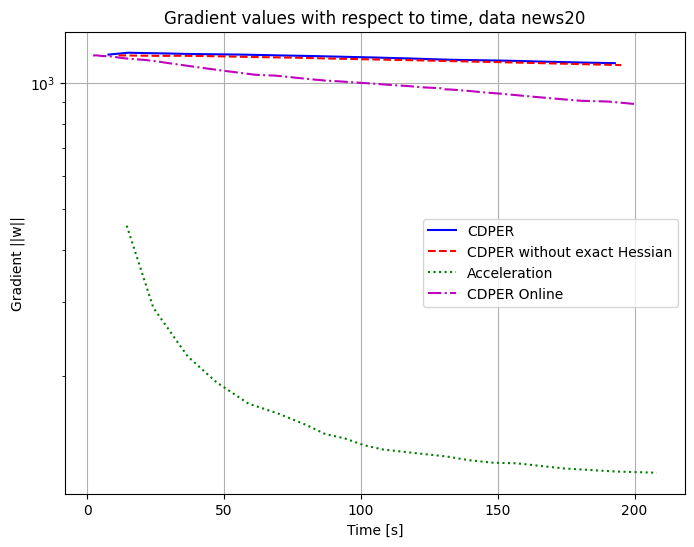

In [62]:
# Gradient values plot
x1_values = [point[0] for point in model1_gradient_values]
y1_values = [point[1] for point in model1_gradient_values]
x2_values = [point[0] for point in model2_gradient_values]
y2_values = [point[1] for point in model2_gradient_values]
x3_values = [point[0] for point in model3_gradient_values]
y3_values = [point[1] for point in model3_gradient_values]
x4_values = [point[0] for point in model4_gradient_values]
y4_values = [point[1] for point in model4_gradient_values]
plotting(x1_values,
         y1_values,
         x2_values,
         y2_values,
         x3_values,
         y3_values,
         x4_values,
         y4_values,
         f'Gradient values with respect to time, data {data_name}',
         'Time [s]',
         'Gradient ||w||',
         'CDPER',
         "CDPER without exact Hessian",
         'Acceleration',
         'CDPER Online',
         log=True)

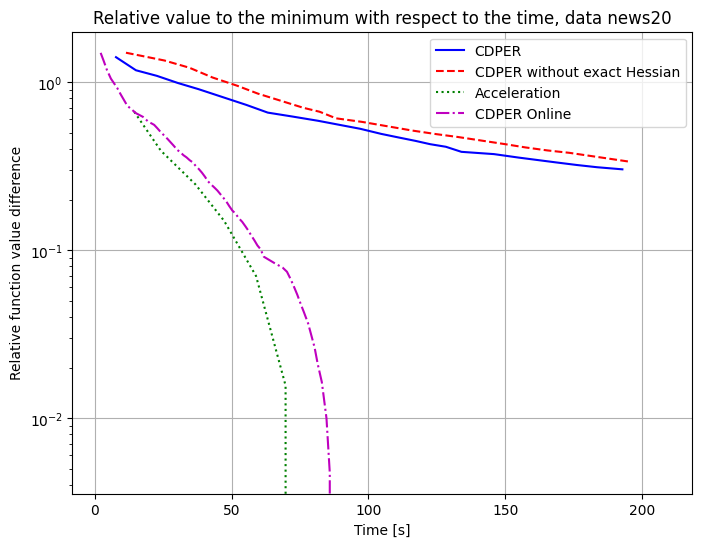

In [63]:
# Objective values plot
x1_values = [point[0] for point in model1_objective_values]
y1_values = [(point[1] - f_w_star) / (np.abs(f_w_star)) for point in model1_objective_values]
x2_values = [point[0] for point in model2_objective_values]
y2_values = [(point[1] - f_w_star) / (np.abs(f_w_star)) for point in model2_objective_values]
x3_values = [point[0] for point in model3_objective_values]
y3_values = [(point[1] - f_w_star) / (np.abs(f_w_star)) for point in model3_objective_values]
x4_values = [point[0] for point in model4_objective_values]
y4_values = [(point[1] - f_w_star) / (np.abs(f_w_star)) for point in model4_objective_values]
plotting(x1_values,
         y1_values,
         x2_values,
         y2_values,
         x3_values,
         y3_values,
         x4_values,
         y4_values,
         f'Relative value to the minimum with respect to the time, data {data_name}',
         'Time [s]',
         'Relative function value difference',
         'CDPER',
         "CDPER without exact Hessian",
         'Acceleration',
         'CDPER Online',
         log=True)

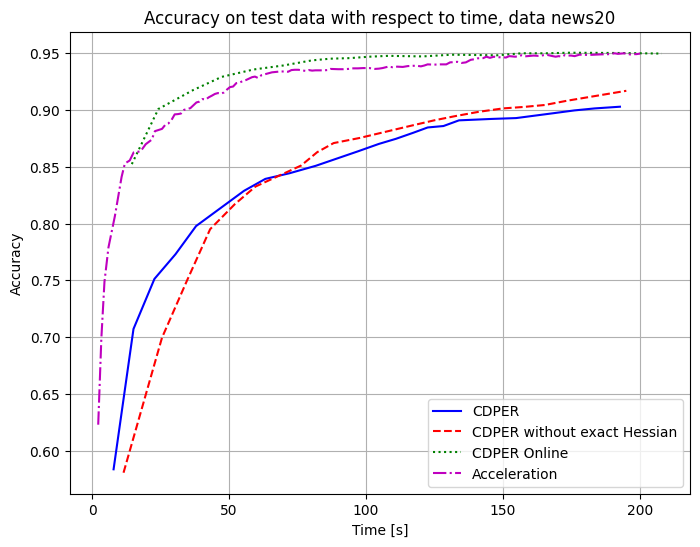

In [64]:
# Accuracy plot
x1_values = [point[0] for point in model1_accuracy_values]
y1_values = [point[1] for point in model1_accuracy_values]
x2_values = [point[0] for point in model2_accuracy_values]
y2_values = [point[1] for point in model2_accuracy_values]
x3_values = [point[0] for point in model3_accuracy_values]
y3_values = [point[1] for point in model3_accuracy_values]
x4_values = [point[0] for point in model4_accuracy_values]
y4_values = [point[1] for point in model4_accuracy_values]
plotting(x1_values,
         y1_values,
         x2_values,
         y2_values,
         x3_values,
         y3_values,
         x4_values,
         y4_values,
         f'Accuracy on test data with respect to time, data {data_name}',
         'Time [s]',
         'Accuracy',
         'CDPER',
         "CDPER without exact Hessian",
         "CDPER Online",
         'Acceleration')